# Stock Price Prediction 

In [2]:
import math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

### 1.1 Loading dataset

In [31]:
tsla_df = pd.read_csv('TSLA_new.csv')

## 2.0 Exploratory Data Analysis 

### 2.1 First 5 rows 

In [32]:
tsla_df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-05-10,21.437332,21.700001,21.208000,21.681334,21.681334,86124000
1,2017-05-11,21.559999,21.733334,21.306667,21.540001,21.540001,71307000
2,2017-05-12,21.698668,21.799999,21.435333,21.653999,21.653999,61824000
3,2017-05-15,21.225332,21.346666,20.835333,21.058666,21.058666,114330000
4,2017-05-16,21.172667,21.337334,21.009333,21.134001,21.134001,62287500


### 2.2 Dropping Unnecessary features 

In [33]:
tsla_df = tsla_df.drop(['Adj Close'], axis=1)
tsla_df

# shape of the dataset = 504-rows x 6-cols

,Date,Open,High,Low,Close,Volume
0,2017-05-10,21.437332,21.700001,21.208000,21.681334,86124000
1,2017-05-11,21.559999,21.733334,21.306667,21.540001,71307000
2,2017-05-12,21.698668,21.799999,21.435333,21.653999,61824000
3,2017-05-15,21.225332,21.346666,20.835333,21.058666,114330000
4,2017-05-16,21.172667,21.337334,21.009333,21.134001,62287500
...,...,...,...,...,...,...
1498,2023-04-24,164.649994,165.649994,158.610001,162.550003,140006600
1499,2023-04-25,159.820007,163.470001,158.750000,160.669998,121999300
1500,2023-04-26,160.289993,160.669998,153.139999,153.750000,153364100
1501,2023-04-27,152.639999,160.479996,152.369995,160.190002,127015200


### 2.3 Checking the count of null / NA values in each feature

In [34]:
tsla_df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

### 2.4 Visualizing if it has null / NA values

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: xlabel='count'>

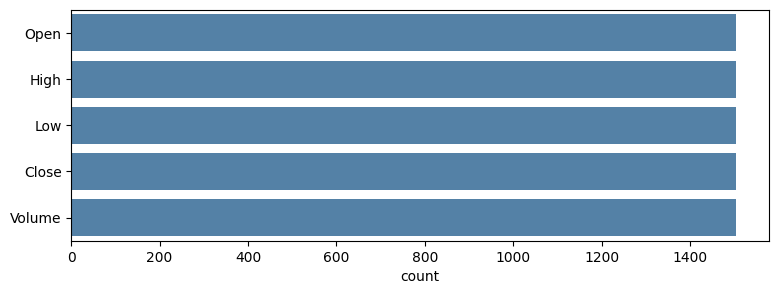

In [35]:
plt.figure(figsize=(9, 3))

sns.countplot(data = tsla_df.iloc[0:], orient='h', color = 'steelblue')          # countplot does not include 'nan' values 

### 2.5 Basic Info of features 

In [36]:
tsla_df.info()                                         # python treats date and datetime as object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1503 non-null   object 
 1   Open    1503 non-null   float64
 2   High    1503 non-null   float64
 3   Low     1503 non-null   float64
 4   Close   1503 non-null   float64
 5   Volume  1503 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 70.6+ KB


### 2.6 Statistical Analysis

In [37]:
tsla_df.describe().apply(lambda s: s.apply('{:.3f}'.format)).T                # or s.apply('{:.5f}'.format)

,count,mean,std,min,25%,50%,75%,max
Open,1503.000,122.346,114.077,12.073,21.277,54.345,224.115,411.470
High,1503.000,125.161,116.686,12.445,21.651,55.067,229.600,414.497
Low,1503.000,119.250,111.119,11.799,20.931,52.437,218.343,405.667
Close,1503.000,122.271,113.917,11.931,21.332,53.721,224.040,409.970
Volume,1503.000,130641015.236,85321986.468,29401800.000,75780000.000,103467000.000,154204150.000,914082000.000


In [38]:
tsla_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1503 non-null   object 
 1   Open    1503 non-null   float64
 2   High    1503 non-null   float64
 3   Low     1503 non-null   float64
 4   Close   1503 non-null   float64
 5   Volume  1503 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 70.6+ KB


### 2.7 Stock Close as data series

In [39]:
df_close = tsla_df['Close']
df_close

0        21.681334
1        21.540001
2        21.653999
3        21.058666
4        21.134001
           ...    
1498    162.550003
1499    160.669998
1500    153.750000
1501    160.190002
1502    164.309998
Name: Close, Length: 1503, dtype: float64

In [40]:
tsla_df.head()

,Date,Open,High,Low,Close,Volume
0,2017-05-10,21.437332,21.700001,21.208000,21.681334,86124000
1,2017-05-11,21.559999,21.733334,21.306667,21.540001,71307000
2,2017-05-12,21.698668,21.799999,21.435333,21.653999,61824000
3,2017-05-15,21.225332,21.346666,20.835333,21.058666,114330000
4,2017-05-16,21.172667,21.337334,21.009333,21.134001,62287500


### 2.8 Plots : Open vs Close,  Low vs High

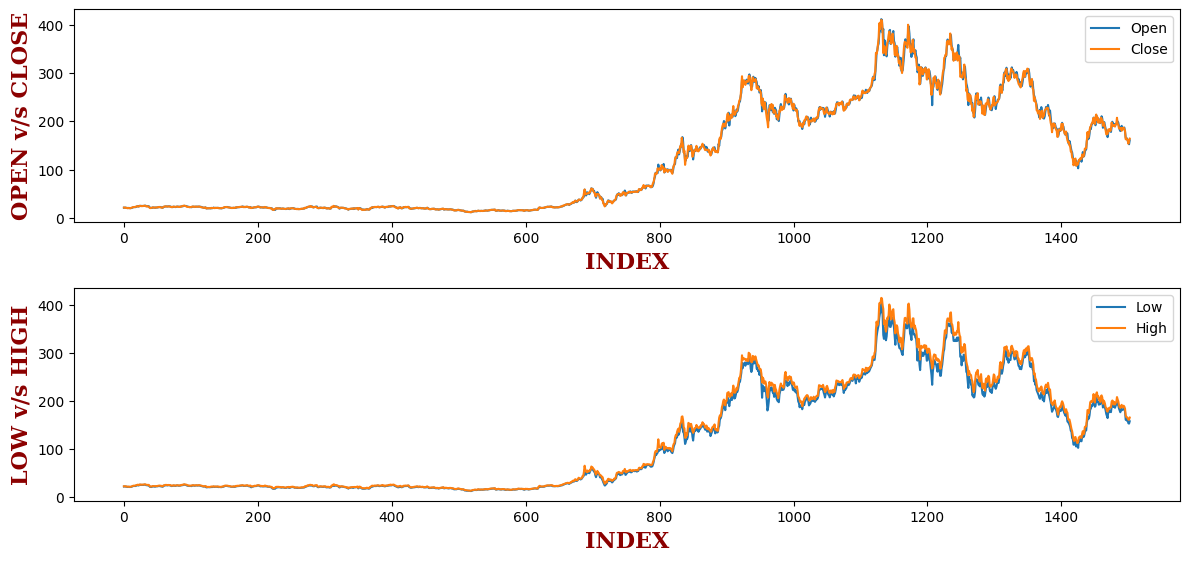

In [41]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'bold',
        'size': 16,
        }

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(tsla_df['Open'], label='Open')
plt.plot(tsla_df['Close'], label='Close')
plt.xlabel('INDEX', fontdict=font)
plt.ylabel('OPEN v/s CLOSE', fontdict=font)
plt.legend()                                                 # legend() : it is an area describing the elements of the graph

plt.subplot(3, 1, 2)
plt.plot(tsla_df['Low'], label='Low')
plt.plot(tsla_df['High'], label='High')
plt.xlabel('INDEX', fontdict=font)
plt.ylabel("LOW v/s HIGH", fontdict=font)
plt.legend()

plt.tight_layout()                                           # tight_layout() : automatically adjusts the subplots in the area

## 3.0 Train - Test Split

### 3.1 MIN_MAX scaler

In [59]:
# LSTM are sensitive to the scale of the data. MIN_MAX scaler will help to convert that data b/w 0 to 1.
# Min value = 0, Max val = 1
# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# eg : (224 - 204) / (409 - 204)  ==  0.0975

scaler = MinMaxScaler(feature_range=(0,1))

# df_close is of type pandas.series i.e, 1-D of shape (504, )
# but scaling object accepts 2-D frame.
# so used np.array to change it into 2-D frame

df_close = scaler.fit_transform(np.array(df_close).reshape(-1, 1))
df_close.shape

# now the shape of df_close is (504, 1)

(1503, 1)

<class 'numpy.ndarray'>


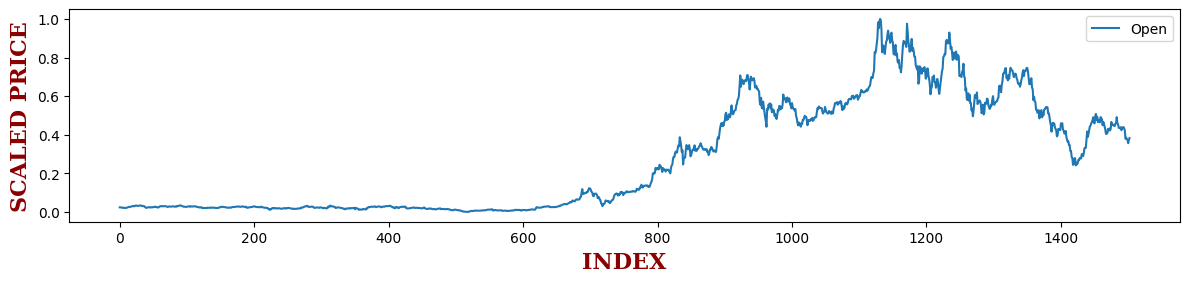

In [60]:
print(type(df_close))
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'bold',
        'size': 16,
        }

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(df_close, label='Open')
plt.xlabel('INDEX', fontdict=font)
plt.ylabel('SCALED PRICE', fontdict=font)
plt.legend()
plt.tight_layout()

### 3.2 Train - Test split, size and data

In [61]:
train_size = int(len(df_close)*0.70)                       # train size = 70%
test_size = len(df_close) - train_size                     # test size = 30%

train_data, test_data = df_close[0:train_size, :], df_close[train_size:len(df_close), :]

In [62]:
train_size, test_size

(1052, 451)

### 3.3 Dividing data

In [63]:
# Whenever we will have time series data, the next data is always dependent on the previous data

def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[(i+time_step), 0])
    
    return np.array(dataX), np.array(dataY)

In [64]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [65]:
X_train.shape, y_train.shape

((951, 100), (951,))

### 3.4 Reshapping the dataset

In [66]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features) 

In [67]:
X_train.shape, y_train.shape

((951, 100, 1), (951,))

## 4.0 Model 

### 4.1 Model Definition

In [68]:
# define Stacked LSTM model
# Models that input or output data sequences are called Sequential Model, eg: text stream, audio, video, time-series data etc.

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape = (time_step, n_features)))
# added one LSTM model of 50 neurons
# Return sequence = True, the output of the hidden state of each neuron is used as an input to the next LSTM layer

model.add(LSTM(50, return_sequences = True, activation='relu'))
model.add(LSTM(50))
model.add(Dense(1))
# Dense layer is added to get output in format needed by the user. It is fully connected layer at the end of neural network

model.compile(loss='mean_squared_error', optimizer='adam')

In [69]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


### 4.2 Fitting data to the model

In [70]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=60, batch_size=64, verbose = 1)

# verbose    : visual representation of epoch processing(0/1/2)
# epochs     : Each time a complete/entire dataset passes through an algorithm, it is said to have completed an epoch.
# batch_size : The training data is always broken down into small batches to overcome the issue that could arise due to 
#              storage space limitations of a computer system.

# This procedure is known as an epoch when all the batches are fed into the model to train at once. 
# Another way to define an epoch is the number of passes a training dataset takes around an algorithm. 
# One pass is counted when the data set has done both forward and backward passes. 
# The number of epochs as well as batch_size is considered a hyperparameter.

Epoch 1/60
15/15 [==============================] - 7s 222ms/step - loss: 0.0307 - val_loss: 0.0082
Epoch 2/60
15/15 [==============================] - 3s 187ms/step - loss: 0.0041 - val_loss: 0.0219
Epoch 3/60
15/15 [==============================] - 3s 188ms/step - loss: 0.0020 - val_loss: 0.0078
Epoch 4/60
15/15 [==============================] - 3s 185ms/step - loss: 0.0014 - val_loss: 0.0102
Epoch 5/60
15/15 [==============================] - 3s 189ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 6/60
15/15 [==============================] - 3s 199ms/step - loss: 9.9321e-04 - val_loss: 0.0057
Epoch 7/60
15/15 [==============================] - 3s 186ms/step - loss: 8.7352e-04 - val_loss: 0.0053
Epoch 8/60
15/15 [==============================] - 3s 187ms/step - loss: 7.9298e-04 - val_loss: 0.0053
Epoch 9/60
15/15 [==============================] - 3s 187ms/step - loss: 7.7883e-04 - val_loss: 0.0085
Epoch 10/60
15/15 [==============================] - 3s 185ms/step - loss: 7.4462e-0

### 4.3 Prediction

In [71]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 37ms/step


### 4.4 Inverse Scaling

In [72]:
train_predict = scaler.inverse_transform(train_predict)
y_train = y_train.reshape(y_train.shape[0], 1)
y_train = scaler.inverse_transform(y_train)
y_test = y_test.reshape(y_test.shape[0], 1)
y_test = scaler.inverse_transform(y_test)
test_predict = scaler.inverse_transform(test_predict)

### 4.5 Plot : Actual v/s Predicted - Train

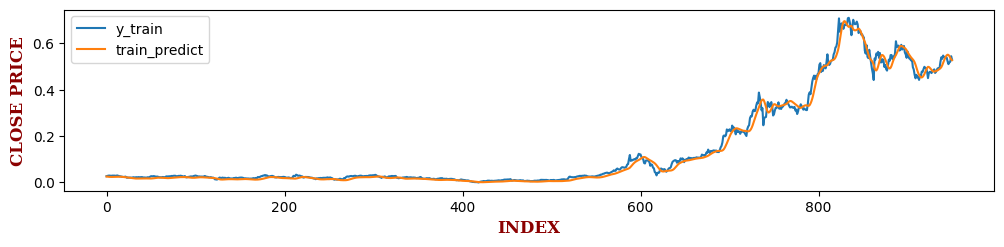

In [73]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'bold',
        'size': 12,
        }

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(y_train, label='y_train')
plt.plot(train_predict, label='train_predict')
plt.xlabel("INDEX", fontdict=font)
plt.ylabel("CLOSE PRICE", fontdict=font)
plt.legend()

### 4.6 Mean Square Error - Training

In [74]:
math.sqrt(mean_squared_error(y_train, train_predict))

0.018058756253826472

### 4.7 Mean Square Error - Test

In [75]:
math.sqrt(mean_squared_error(y_test, test_predict))

0.053111379618346305

### 4.8 Plot : Actual vs Predicted : Complete DataSet

In [76]:
# first 50 will be vacant
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, : ] = train_predict

testPredictPlot = np.empty_like(df_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+2*time_step+1:len(df_close)-1, :] = test_predict

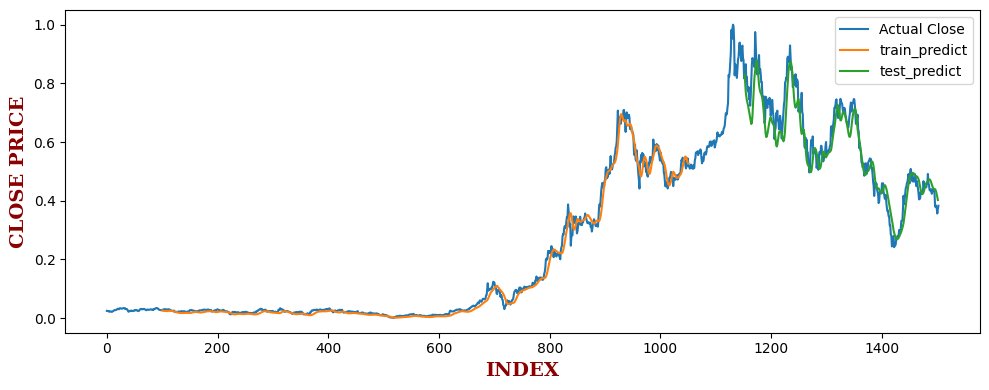

In [77]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'bold',
        'size': 14,
        }

plt.figure(figsize=(10, 4))
plt.subplot(1, 1, 1)
plt.plot(scaler.inverse_transform(df_close), label='Actual Close')
plt.plot(trainPredictPlot, label='train_predict')
plt.plot(testPredictPlot, label='test_predict')
plt.xlabel('INDEX', fontdict=font)
plt.ylabel('CLOSE PRICE', fontdict=font)
plt.legend()                                                 # legend() : it is an area describing the elements of the graph

plt.tight_layout()                                           # tight_layout() : automatically adjusts the subplots in the area

## 5.0 Next 30 - Days Prediction

In [78]:
len(test_data)

451

In [79]:
x_input = test_data[351: ].reshape(1, -1)
print(type(x_input))
print(x_input.shape)

<class 'numpy.ndarray'>
(1, 100)


In [80]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
print(len(temp_input))
print(type(temp_input))

100
<class 'list'>


In [81]:
# predicting the next 30 days 

lst_output = []
i=0

while(i<30):
    if(len(temp_input)>100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        y_input = model.predict(x_input, verbose=0)
        temp_input.extend(y_input[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(y_input[0].tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_input = model.predict(x_input)
        temp_input.extend(y_input[0].tolist())
        lst_output.extend(y_input[0].tolist())
        i=i+1

1/1 [==============================] - 0s 32ms/step


### 5.2 Plot : Next 30 Day 

In [82]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)

In [83]:
len(df_close)

1503

In [84]:
lst_df = pd.DataFrame(lst_output)

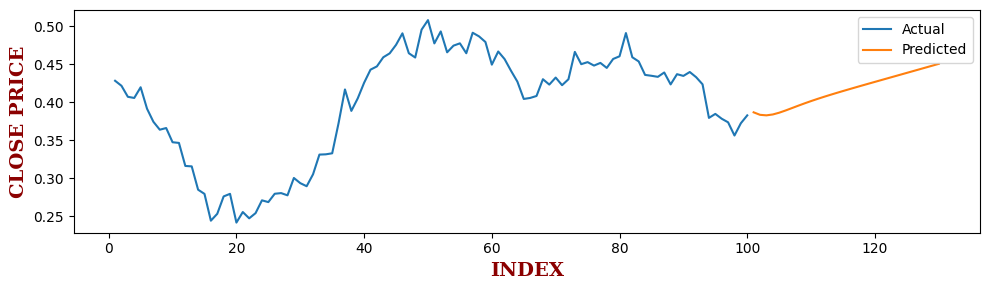

In [85]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'bold',
        'size': 14,
        }

plt.figure(figsize=(10, 3))
plt.subplot(1, 1, 1)
plt.plot(day_new, scaler.inverse_transform(df_close[1403:]), label = "Actual")
plt.plot(day_pred, scaler.inverse_transform(lst_df), label = "Predicted")
plt.xlabel('INDEX', fontdict=font)
plt.ylabel('CLOSE PRICE', fontdict=font)
plt.legend()                                                 # legend() : it is an area describing the elements of the graph

plt.tight_layout()      

### 5.3 Formatting in suitable format to Plot

In [86]:
arr = np.array(df_close[:])
arr = arr.reshape(1, -1)
temp = list(arr)
temp = temp[0].tolist()
temp.extend(lst_output)
final_df = pd.DataFrame(temp)

### 5.4 FINAL PLOT - AFTER INDEX 500

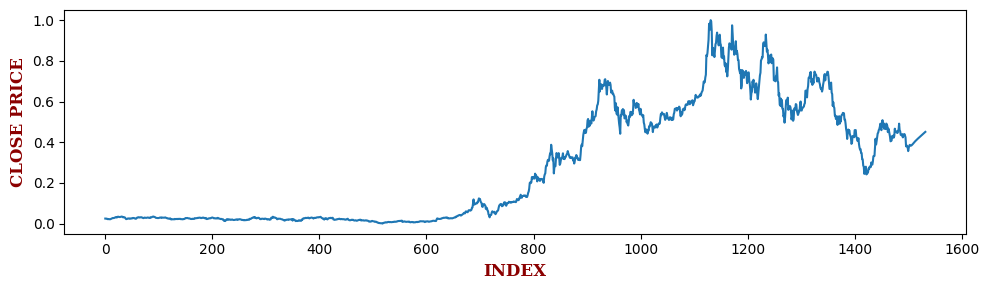

In [87]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'bold',
        'size': 12,
        }

plt.figure(figsize=(10, 3))
plt.subplot(1, 1, 1)
plt.plot(scaler.inverse_transform(final_df))
plt.xlabel('INDEX', fontdict=font)
plt.ylabel('CLOSE PRICE', fontdict=font)
plt.tight_layout()